# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [6]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.336277
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** With the initial W we expect equal probabilities for all the classes -> p=0.1 ...


In [31]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -4.126329 analytic: -4.126329, relative error: 8.910383e-09
numerical: 1.969257 analytic: 1.969257, relative error: 1.261722e-08
numerical: 2.182239 analytic: 2.182238, relative error: 2.830368e-08
numerical: -2.082838 analytic: -2.082837, relative error: 1.909990e-08
numerical: -1.007282 analytic: -1.007282, relative error: 3.649227e-08
numerical: 0.560314 analytic: 0.560314, relative error: 3.255759e-08
numerical: 1.053710 analytic: 1.053710, relative error: 1.582188e-08
numerical: -0.313903 analytic: -0.313904, relative error: 1.263051e-07
numerical: 0.261063 analytic: 0.261063, relative error: 4.114346e-10
numerical: 2.467062 analytic: 2.467062, relative error: 9.846804e-09
numerical: -0.766395 analytic: -0.766395, relative error: 1.094186e-07
numerical: 2.773312 analytic: 2.773312, relative error: 1.457865e-08
numerical: 0.135142 analytic: 0.135142, relative error: 8.133461e-08
numerical: -1.275068 analytic: -1.275068, relative error: 1.585376e-08
numerical: -0.232577 a

In [54]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.336277e+00 computed in 0.152041s
vectorized loss: 2.336277e+00 computed in 0.008984s
Loss difference: 0.000000
Gradient difference: 0.000000


In [56]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
num_val = 20
learning_rates = 10 ** np.random.uniform(-7, -6, num_val)
regularization_strengths = 10 ** np.random.uniform(3, 4, num_val)

################################################################################
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################


num_itr = 2000
for i in range(num_val):
    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rate=learning_rates[i], 
                          reg=regularization_strengths[i], num_iters=num_itr,
                          verbose=False)
    y_val_pred = softmax.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    y_train_pred = softmax.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    results[(learning_rates[i], regularization_strengths[i])] = (train_accuracy,
                                                                 val_accuracy)
    if val_accuracy>best_val:
        best_val = val_accuracy
        best_softmax = softmax    

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.183910e-07 reg 3.697096e+03 train accuracy: 0.324367 val accuracy: 0.329000
lr 1.338706e-07 reg 1.003065e+03 train accuracy: 0.290510 val accuracy: 0.299000
lr 1.807446e-07 reg 1.047925e+03 train accuracy: 0.307449 val accuracy: 0.293000
lr 1.838071e-07 reg 3.315537e+03 train accuracy: 0.357286 val accuracy: 0.356000
lr 2.192417e-07 reg 1.972154e+03 train accuracy: 0.349816 val accuracy: 0.363000
lr 2.293930e-07 reg 6.742348e+03 train accuracy: 0.382408 val accuracy: 0.382000
lr 2.399298e-07 reg 4.589387e+03 train accuracy: 0.386857 val accuracy: 0.396000
lr 2.534207e-07 reg 4.133229e+03 train accuracy: 0.385816 val accuracy: 0.384000
lr 3.426715e-07 reg 2.667618e+03 train accuracy: 0.390245 val accuracy: 0.398000
lr 3.812099e-07 reg 2.180215e+03 train accuracy: 0.392898 val accuracy: 0.398000
lr 3.869994e-07 reg 3.931525e+03 train accuracy: 0.389714 val accuracy: 0.392000
lr 3.979742e-07 reg 9.093548e+03 train accuracy: 0.373878 val accuracy: 0.389000
lr 5.668107e-07 reg 1.092297

In [57]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.380000


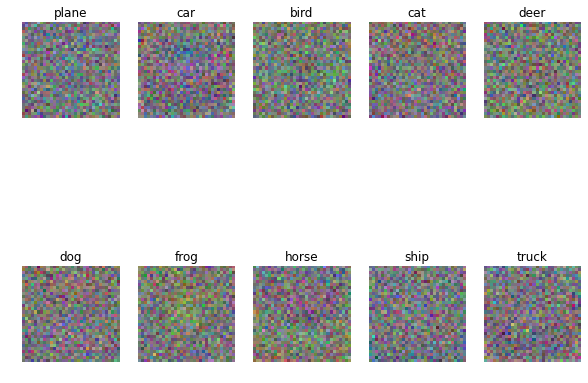

In [58]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])